Model Requirements (hugging face):

1: Sentiment Analysis Models\
2: NPS Formula from Model Rating (Adjust to 5 Star Rating 0-2, 3, 4-5)
3: Identify Trends + Common Customer Feedback (Word Clouds / Top Common Words etc..., Word Cloud Visuals)\
4: Reccomendation System for actions to take (From word cloud etc... from GXS Reviews)
5. Future actions (Word Cloud from other banks reviews)

In [1]:
# Setting Up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('tableau-colorblind10')

import nltk

In [2]:
# Read in data
GXS_Apple = pd.read_csv('https://raw.githubusercontent.com/HaoEarm/DSA3101_Project/main/Data/GXS_Bank_Apple.csv', index_col=0)
GXS_Google = pd.read_csv('https://raw.githubusercontent.com/HaoEarm/DSA3101_Project/main/Data/GXS_Bank_Google.csv', index_col=0)

In [3]:
# Combine for Training Data
df_merged = pd.concat([GXS_Apple, GXS_Google], ignore_index=True, sort=False)

In [4]:
df_merged['No.'] = df_merged.reset_index().index

In [5]:
df_merged.head()

,UserName,Review,Score,Date,Bank,No.
0,Tiny Particles,The app is easy to navigate and optimise for p...,5,2024-02-25 07:24:03,GXS Bank,0
1,HetTienDownGameBanQuyen,Extremely disappointed with the GXS app. Despi...,1,2024-02-24 06:12:02,GXS Bank,1
2,Nrhdxtan,Show allow to increase amount not reduce and s...,1,2024-02-21 14:03:59,GXS Bank,2
3,OnTheRoad9988,This app is easy to use.,5,2024-02-10 03:22:39,GXS Bank,3
4,princesstazsdff,When you asked your staff to write a 5* review...,1,2024-01-18 08:45:46,GXS Bank,4


In [6]:
# Initial Data Exploration of Dataset
# Index Col
# UserName
# Review (Text)
# Score
# Date
# Bank

In [7]:
# Visualising brekdown of Scores given by Users in df
Scores = df_merged['Score'].value_counts()
Scores

1    161
5    116
3     17
2     14
4      8
Name: Score, dtype: int64

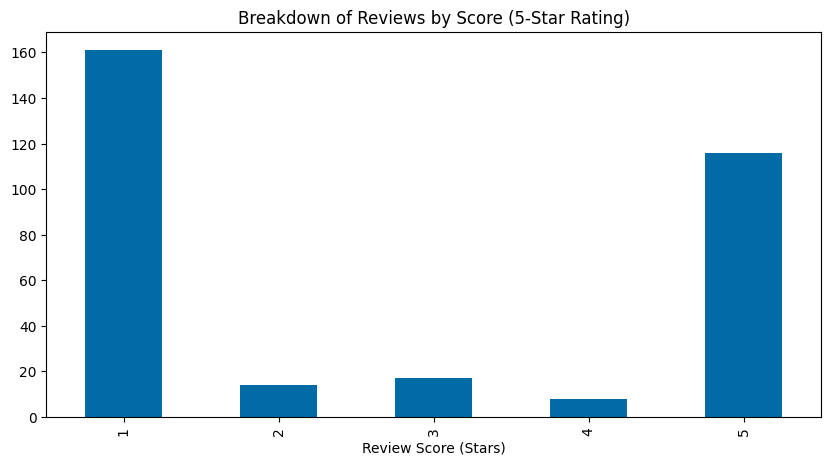

In [8]:
# Plotting Scores in sorted order
Score_plot = Scores.sort_index().plot(kind = 'bar',
                         title = "Breakdown of Reviews by Score (5-Star Rating)",
                        figsize = (10,5))
Score_plot.set_xlabel('Review Score (Stars)')
plt.show()
# Majority of Reviews are either 1 or 5 stars

In [9]:
# Setting up Pthon NLTK
example = df_merged['Review'][0]
print(example)

The app is easy to navigate and optimise for people of all ages.


In [10]:
# Tokenzing a sample text review
nltk.download('punkt')
sample_tokens = nltk.word_tokenize(example)
sample_tokens[:10]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['The',
 'app',
 'is',
 'easy',
 'to',
 'navigate',
 'and',
 'optimise',
 'for',
 'people']

In [11]:
# Part of Speech Tagging
nltk.download('averaged_perceptron_tagger')
sample_tagged = nltk.pos_tag(sample_tokens)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [12]:
# Grouping tagged words into chunks of text
nltk.download('words')
nltk.download('maxent_ne_chunker')
entities = nltk.chunk.ne_chunk(sample_tagged)
entities.pprint()

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


(S
  The/DT
  app/NN
  is/VBZ
  easy/JJ
  to/TO
  navigate/VB
  and/CC
  optimise/VB
  for/IN
  people/NNS
  of/IN
  all/DT
  ages/NNS
  ./.)


In [13]:
# distilbert-base-multilingual-cased-sentiments-student from HuggingFace

# Setting up
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import torch
from transformers import RobertaForSequenceClassification
from tqdm.notebook import tqdm

In [14]:
from transformers import pipeline
#https://huggingface.co/lxyuan/distilbert-base-multilingual-cased-sentiments-student

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    top_k=None
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [15]:
# Run distilbert on first example text
output = distilled_student_sentiment_classifier(example)

In [16]:
print(output)

[[{'label': 'positive', 'score': 0.843580961227417}, {'label': 'neutral', 'score': 0.11614909023046494}, {'label': 'negative', 'score': 0.04026997089385986}]]


In [17]:
# Extract Scores from output
output[0][0]['score']

0.843580961227417

In [18]:
# Store results into dict
scores_dict = {
    'positive' : output[0][0]['score'],
    'neutral' : output[0][1]['score'],
    'negative' : output[0][2]['score']
}

In [19]:
print(scores_dict)

{'positive': 0.843580961227417, 'neutral': 0.11614909023046494, 'negative': 0.04026997089385986}


In [20]:
def distilbert_scores(example):
    # Run distilbert on first example text
    output = distilled_student_sentiment_classifier(example)

    # Store results into dict
    scores_dict = {
    'positive' : output[0][0]['score'],
    'neutral' : output[0][1]['score'],
    'negative' : output[0][2]['score']
    }

    return scores_dict

In [21]:
res = {}
for i, row in tqdm(df_merged.iterrows(), total = len(df_merged)):

    # Running distilbert
    try:
        text_review = row['Review']
        num = row['No.']

        # Running distilbert
        res[num] = distilbert_scores(text_review)

    except RuntimeError:
        print(f'Broke for Review Number:{num}')

  0%|          | 0/316 [00:00<?, ?it/s]

In [22]:
print(res)

{0: {'positive': 0.843580961227417, 'neutral': 0.11614909023046494, 'negative': 0.04026997089385986}, 1: {'positive': 0.7385880351066589, 'neutral': 0.19523946940898895, 'negative': 0.06617249548435211}, 2: {'positive': 0.4643169343471527, 'neutral': 0.3157537877559662, 'negative': 0.21992924809455872}, 3: {'positive': 0.8223872184753418, 'neutral': 0.15265151858329773, 'negative': 0.02496131882071495}, 4: {'positive': 0.6502248048782349, 'neutral': 0.2101144939661026, 'negative': 0.13966071605682373}, 5: {'positive': 0.41327643394470215, 'neutral': 0.36858370900154114, 'negative': 0.2181398868560791}, 6: {'positive': 0.9447067975997925, 'neutral': 0.03158464655280113, 'negative': 0.023708544671535492}, 7: {'positive': 0.9375831484794617, 'neutral': 0.05256223678588867, 'negative': 0.009854605421423912}, 8: {'positive': 0.8714383840560913, 'neutral': 0.08821138739585876, 'negative': 0.040350209921598434}, 9: {'positive': 0.6321708559989929, 'neutral': 0.20337127149105072, 'negative': 0

In [23]:
# Read into pandas DataFrame
res_df = pd.DataFrame.from_dict(res, orient='index')
df_merged2 = pd.concat([df_merged, res_df], axis=1, join="inner")

In [24]:
# Check merge
df_merged2.head()

,UserName,Review,Score,Date,Bank,No.,positive,neutral,negative
0,Tiny Particles,The app is easy to navigate and optimise for p...,5,2024-02-25 07:24:03,GXS Bank,0,0.843581,0.116149,0.040270
1,HetTienDownGameBanQuyen,Extremely disappointed with the GXS app. Despi...,1,2024-02-24 06:12:02,GXS Bank,1,0.738588,0.195239,0.066172
2,Nrhdxtan,Show allow to increase amount not reduce and s...,1,2024-02-21 14:03:59,GXS Bank,2,0.464317,0.315754,0.219929
3,OnTheRoad9988,This app is easy to use.,5,2024-02-10 03:22:39,GXS Bank,3,0.822387,0.152652,0.024961
4,princesstazsdff,When you asked your staff to write a 5* review...,1,2024-01-18 08:45:46,GXS Bank,4,0.650225,0.210114,0.139661


In [25]:
# Numeric Breakdown of Scores
df_merged2[['negative', 'neutral', 'positive']].describe(include="all")

,negative,neutral,positive
count,316.000000,316.000000,316.000000
mean,0.132988,0.226576,0.640436
std,0.083829,0.116036,0.186068
min,0.002175,0.004383,0.348678
25%,0.054234,0.131291,0.472437
50%,0.132492,0.238719,0.610475
75%,0.196985,0.324950,0.800757
max,0.319966,0.450731,0.993442


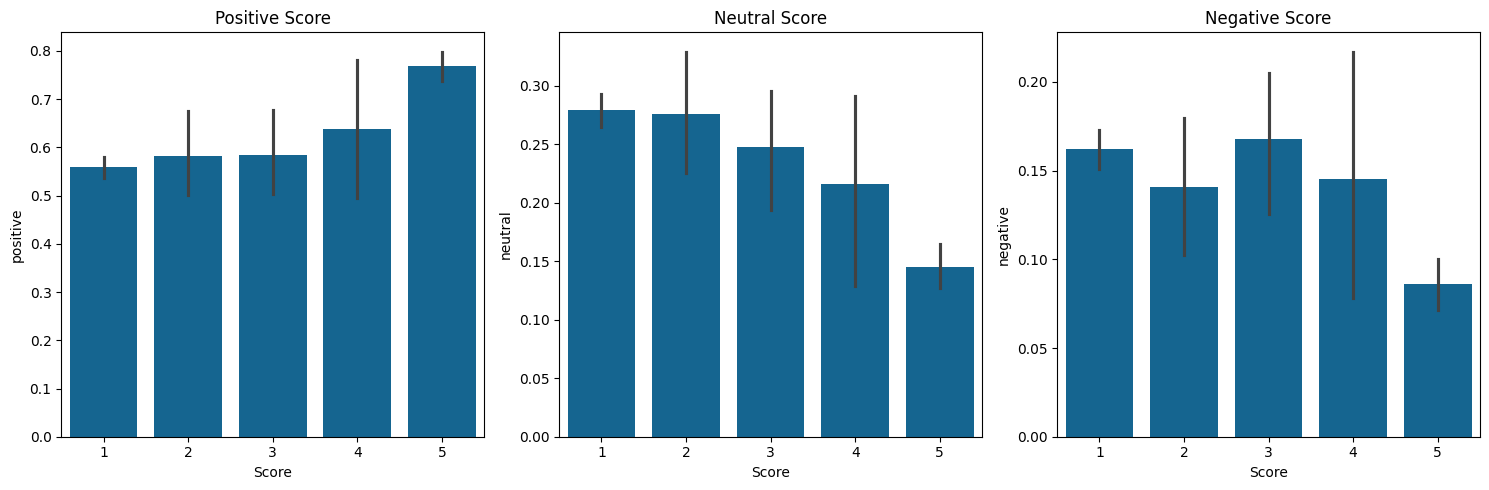

In [26]:
# Plotting out the scores
# Check if higher scores will lead to more higher rated reviews
fig , axs = plt.subplots(1,3, figsize = (15,5))
sns.barplot(data = df_merged2, x = 'Score', y = 'positive', ax = axs[0])
sns.barplot(data = df_merged2, x = 'Score', y = 'neutral', ax = axs[1])
sns.barplot(data = df_merged2, x = 'Score', y = 'negative', ax = axs[2])
axs[0].set_title("Positive Score")
axs[1].set_title("Neutral Score")
axs[2].set_title("Negative Score")
plt.tight_layout()
plt.show()

In [27]:
# Looking at Outliers

# The most positive 1-star review according to Roberta
df_merged2.query('Score == 1').sort_values('positive', ascending = False)['Review'].values[0]

# Review is too short to draw any relationship with the score

'Good'

In [28]:
# The most negative 5-star review
df_merged2.query('Score == 5').sort_values('negative', ascending = False)['Review'].values[0]

# Sentiment is indeed negative, but reviewer still gave 5 stars

'You app downloading alway show technical priblem why??'

In [29]:
# Calculate NPS Score
# (Adjust to 5 Star Rating 0-2, 3, 4-5)
# https://www.qualtrics.com/au/experience-management/customer/net-promoter-score/
conditions = [
    (df_merged2['Score'] <= 2),
    (df_merged2['Score'] == 3 ),
    (df_merged2['Score'] >= 4)
]

values = ['Detractor', 'Passive', 'Promoter']

df_merged2['NPS category'] = np.select(conditions, values)
print(df_merged2.head())

                  UserName                                             Review  \
0           Tiny Particles  The app is easy to navigate and optimise for p...   
1  HetTienDownGameBanQuyen  Extremely disappointed with the GXS app. Despi...   
2                 Nrhdxtan  Show allow to increase amount not reduce and s...   
3            OnTheRoad9988                           This app is easy to use.   
4          princesstazsdff  When you asked your staff to write a 5* review...   

   Score                 Date      Bank  No.  positive   neutral  negative  \
0      5  2024-02-25 07:24:03  GXS Bank    0  0.843581  0.116149  0.040270   
1      1  2024-02-24 06:12:02  GXS Bank    1  0.738588  0.195239  0.066172   
2      1  2024-02-21 14:03:59  GXS Bank    2  0.464317  0.315754  0.219929   
3      5  2024-02-10 03:22:39  GXS Bank    3  0.822387  0.152652  0.024961   
4      1  2024-01-18 08:45:46  GXS Bank    4  0.650225  0.210114  0.139661   

  NPS category  
0     Promoter  
1    Detra

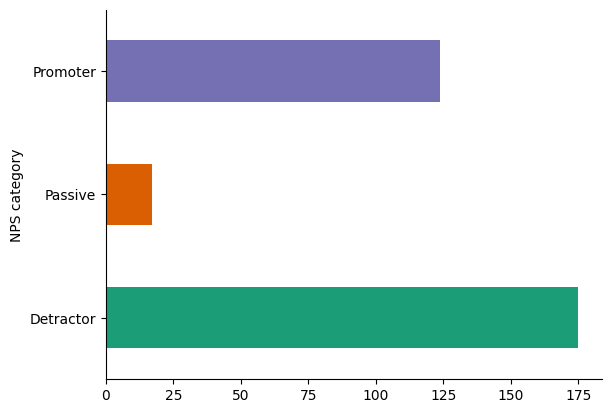

In [30]:
# Plotting out NPS Categories
df_merged2.groupby('NPS category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [31]:
nps_res = df_merged2['NPS category'].value_counts(normalize=True)

In [32]:
# Promoter - Detractor / Total
print("NPS Score %:")
print((nps_res['Promoter'] - nps_res['Detractor']) *100)

NPS Score %:
-16.13924050632911


In [33]:
# Tokenization
from wordcloud import WordCloud, STOPWORDS
promoter_reviews = df_merged2['Review'][df_merged2["NPS category"] == 'Promoter']

promoter_reviews_tokenised = ""
for val in promoter_reviews:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    promoter_reviews_tokenised += " ".join(tokens)+" "

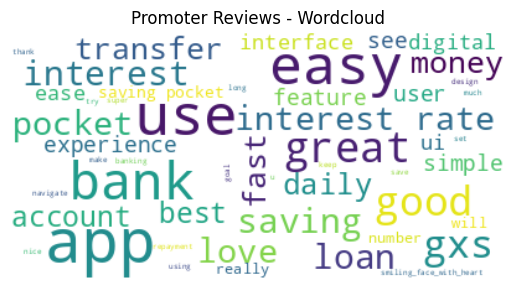

In [34]:
# Word Cloud
# https://medium.com/@harinisureshla/wordclouds-basics-of-nlp-5b60be226414

stop_words = ["dtype", 'p' + 'didnt' + 'dis'] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", stopwords = stop_words).generate(str(promoter_reviews_tokenised))
plt.figure()
plt.title("Promoter Reviews - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [35]:
# Tokenization
detractor_reviews = df_merged2['Review'][df_merged2["NPS category"] == 'Detractor']

detractor_reviews_tokenised = ""
for val in promoter_reviews:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    detractor_reviews_tokenised += " ".join(tokens)+" "

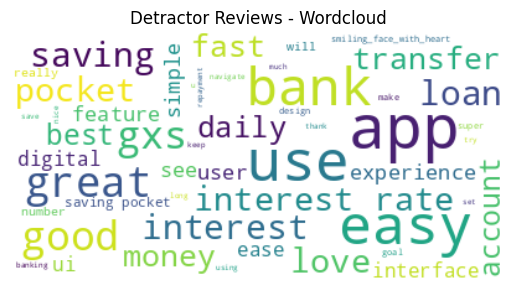

In [36]:
stop_words = ["dtype", 'p' + 'didnt' + 'dis'] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", stopwords = stop_words).generate(str(detractor_reviews_tokenised))
plt.figure()
plt.title("Detractor Reviews - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [37]:
# Checking reviews of other banks
# E.g. Trust Bank
Trust_Apple = pd.read_csv('https://raw.githubusercontent.com/HaoEarm/DSA3101_Project/main/Data/Trust_apple.csv', index_col=0)
Trust_Apple['No.'] = Trust_Apple.reset_index().index
Trust_Apple.head()

,Review,Score,Date,Bank,No.
UserName,,,,,
Kaylene Ho,Worst bank to have a credit card with.,1,2024-03-07 17:42:15,Trust,0
Increadible Jade,I’ve tried to make payments via QR codes many ...,1,2024-03-07 16:54:18,Trust,1
Suet said,Great,3,2024-03-07 02:20:32,Trust,2
SKT yes,Fast n easy,4,2024-03-03 11:17:29,Trust,3
Arr1808,Don’t believe them if they say they’ll contact...,1,2024-03-03 00:49:53,Trust,4


In [38]:
res = {}
for i, row in tqdm(Trust_Apple.iterrows(), total = len(Trust_Apple)):

    # Running distilbert
    try:
        text_review = row['Review']
        num = row['No.']

        # Running distilbert
        res[num] = distilbert_scores(text_review)

    except RuntimeError:
        print(f'Broke for Review Number:{num}')

  0%|          | 0/524 [00:00<?, ?it/s]

In [39]:
res_df.head()

,positive,neutral,negative
0,0.843581,0.116149,0.040270
1,0.738588,0.195239,0.066172
2,0.464317,0.315754,0.219929
3,0.822387,0.152652,0.024961
4,0.650225,0.210114,0.139661


In [40]:
# Read into pandas DataFrame
res_df = pd.DataFrame.from_dict(res, orient='index')

df_trust = pd.concat(
    [Trust_Apple.reset_index(), res_df.reset_index()], axis = 1)

In [41]:
df_trust.head()

,UserName,Review,Score,Date,Bank,No.,index,positive,neutral,negative
0,Kaylene Ho,Worst bank to have a credit card with.,1,2024-03-07 17:42:15,Trust,0,0,0.431380,0.325669,0.242951
1,Increadible Jade,I’ve tried to make payments via QR codes many ...,1,2024-03-07 16:54:18,Trust,1,1,0.626400,0.197018,0.176583
2,Suet said,Great,3,2024-03-07 02:20:32,Trust,2,2,0.681144,0.175736,0.143120
3,SKT yes,Fast n easy,4,2024-03-03 11:17:29,Trust,3,3,0.531676,0.285875,0.182449
4,Arr1808,Don’t believe them if they say they’ll contact...,1,2024-03-03 00:49:53,Trust,4,4,0.540860,0.342829,0.116311


In [42]:
# Numeric Breakdown of Scores
df_trust[['negative', 'neutral', 'positive']].describe(include="all")

,negative,neutral,positive
count,524.000000,524.000000,524.000000
mean,0.130352,0.221535,0.648113
std,0.080779,0.112039,0.178675
min,0.001911,0.007000,0.339891
25%,0.063845,0.127823,0.495247
50%,0.123394,0.237574,0.623188
75%,0.190631,0.314718,0.803774
max,0.327870,0.448162,0.989275


In [43]:
# Calculate NPS Score
# (Adjust to 5 Star Rating 0-2, 3, 4-5)
# https://www.qualtrics.com/au/experience-management/customer/net-promoter-score/
conditions = [
    (df_trust['Score'] <= 2),
    (df_trust['Score'] == 3 ),
    (df_trust['Score'] >= 4)
]

values = ['Detractor', 'Passive', 'Promoter']

df_trust['NPS category'] = np.select(conditions, values)
print(df_trust.head())

           UserName                                             Review  Score  \
0        Kaylene Ho             Worst bank to have a credit card with.      1   
1  Increadible Jade  I’ve tried to make payments via QR codes many ...      1   
2         Suet said                                              Great      3   
3           SKT yes                                        Fast n easy      4   
4           Arr1808  Don’t believe them if they say they’ll contact...      1   

                  Date   Bank  No.  index  positive   neutral  negative  \
0  2024-03-07 17:42:15  Trust    0      0  0.431380  0.325669  0.242951   
1  2024-03-07 16:54:18  Trust    1      1  0.626400  0.197018  0.176583   
2  2024-03-07 02:20:32  Trust    2      2  0.681144  0.175736  0.143120   
3  2024-03-03 11:17:29  Trust    3      3  0.531676  0.285875  0.182449   
4  2024-03-03 00:49:53  Trust    4      4  0.540860  0.342829  0.116311   

  NPS category  
0    Detractor  
1    Detractor  
2      Pass

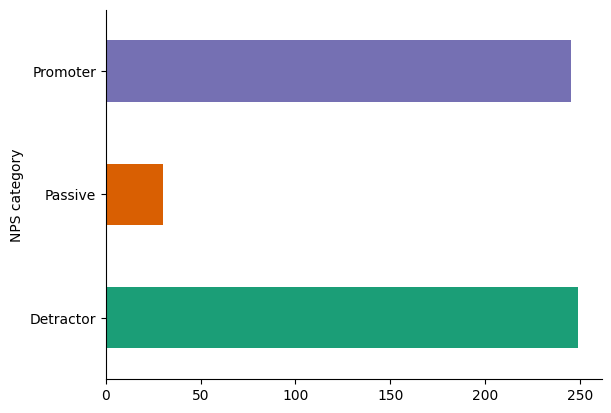

In [44]:
# Plotting out NPS Categories
df_trust.groupby('NPS category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [45]:
trust_nps_res = df_trust['NPS category'].value_counts(normalize=True)

In [46]:
# Promoter - Detractor / Total
print("Trust NPS Score %:")
print((trust_nps_res['Promoter'] - trust_nps_res['Detractor']) *100)

Trust NPS Score %:
-0.7633587786259555


In [47]:
# Tokenization
trust_promoter_reviews = df_trust['Review'][df_trust["NPS category"] == 'Promoter']

trust_promoter_reviews_tokenised = ""
for val in trust_promoter_reviews:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    trust_promoter_reviews_tokenised += " ".join(tokens)+" "

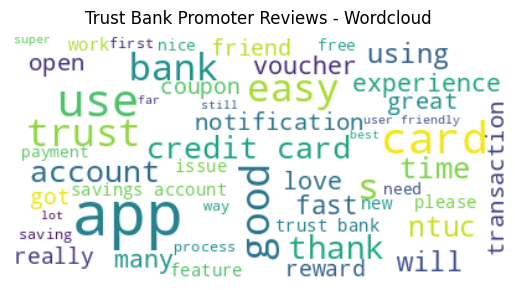

In [48]:
stop_words = ["dtype", 'p' + 'didnt' + 'dis'] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", stopwords = stop_words).generate(str(trust_promoter_reviews_tokenised))
plt.figure()
plt.title("Trust Bank Promoter Reviews - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [49]:
# Tokenization
trust_detractor_reviews = df_trust['Review'][df_trust["NPS category"] == 'Detractor']

trust_detractor_reviews_tokenised = ""
for val in trust_detractor_reviews:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    trust_detractor_reviews_tokenised += " ".join(tokens)+" "

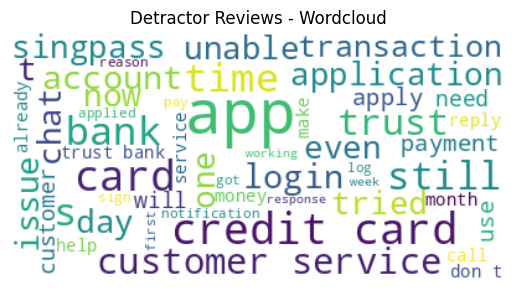

In [50]:
stop_words = ["dtype", 'p' + 'didnt' + 'dis'] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white", stopwords = stop_words).generate(str(trust_detractor_reviews_tokenised))
plt.figure()
plt.title("Detractor Reviews - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()